### test deepar tensorflow

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from numpy.random import normal
import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

#from indycar.model.deepartf.dataset.time_series import MockTs
from indycar.model.deepartf.dataset.time_series import RecordTs
from indycar.model.deepartf.model.lstm import DeepAR

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
def get_sample_prediction_gaussian(sample, fn):
    sample = np.array(sample).reshape(1, _seq_len, 1)
    output = fn([sample])
    samples = []
    for mu,sigma in zip(output[0].reshape(_seq_len), output[1].reshape(_seq_len)):
        samples.append(normal(loc=mu, scale=np.sqrt(sigma), size=1)[0])
    return np.array(samples)

def get_sample_prediction(sample, model, verbose = False):
    sample = np.array(sample).reshape(1, _seq_len, -1)
    output = model.predict([sample])
    
    output2 = np.zeros((_seq_len, len(output)))
    for idx, x in enumerate(output):
        output2[:,idx] = x.reshape(_seq_len)
        
    #output2 = np.array(output).reshape(_seq_len, -1)
    if verbose:
        print('output.shape=',[len(x) for x in output])
        print('output:', output)
        print('output2.shape=', output2.shape)
        print('output2:', output2)
    
    samples = []
    #for theta in zip(output[0].reshape(_seq_len), output[1].reshape(_seq_len)):
    for theta in output2:
        samples.append(model.get_sample(theta))
    return np.array(samples)

In [22]:
def predict(model):
    #batch = ts.next_batch(_batch_size, _seq_len)
    batch = ts.next_batch(-1, _seq_len)

    #get_sample_prediction(batch[0], model, verbose=True)
    #get_sample_prediction(batch[0], model, verbose=True)
    
    ress = []
    for i in tqdm.tqdm(range(300)):
        #ress.append(get_sample_prediction(batch[0], model.predict_theta_from_input))
        ress.append(get_sample_prediction(batch[0], model))

    res_df = pd.DataFrame(ress).T
    tot_res = res_df

    plt.plot(batch[1].reshape(_seq_len), linewidth=6)
    tot_res['mu'] = tot_res.apply(lambda x: np.mean(x), axis=1)
    tot_res['upper'] = tot_res.apply(lambda x: np.mean(x) + np.std(x), axis=1)
    tot_res['lower'] = tot_res.apply(lambda x: np.mean(x) - np.std(x), axis=1)
    tot_res['two_upper'] = tot_res.apply(lambda x: np.mean(x) + 2*np.std(x), axis=1)
    tot_res['two_lower'] = tot_res.apply(lambda x: np.mean(x) - 2*np.std(x), axis=1)

    plt.plot(tot_res.mu, 'bo')
    plt.plot(tot_res.mu, linewidth=2)
    plt.fill_between(x = tot_res.index, y1=tot_res.lower, y2=tot_res.upper, alpha=0.5)
    plt.fill_between(x = tot_res.index, y1=tot_res.two_lower, y2=tot_res.two_upper, alpha=0.5)
    plt.title('Prediction uncertainty')
    
    return batch, tot_res

In [16]:
ts = RecordTs('savedata_drank_e1.pickle')
_context_len = 40
_prediction_len = 2
_batch_size = 32
_seq_len = _context_len + _prediction_len

dataset shape: (32, 42, 33)
target shape: (32, 42)


In [24]:
#model2 = DeepAR(ts, epochs=5,distribution='StudentT')
model3 = DeepAR(ts, epochs=5,distribution='StudentT',with_custom_nn_structure=DeepAR.encoder_decoder)
model3.fit(context_len=_context_len, prediction_len=_prediction_len, input_dim = 33)

y_true.shape=(None, None, None)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 42, 33)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 42, 40)            11840     
_________________________________________________________________
lstm_7 (LSTM)                (None, 42, 40)            12960     
_________________________________________________________________
main_output (StudentTLayer)  [(None, 42, 1), (None, 42 123       
Total params: 24,923
Trainable params: 24,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
50/50 [==============================] - 9s 181ms/step - loss: 5.5305
Epoch 2/5
50/50 [==============================] - 8s 156ms/step - loss: 4.0303
Epoch 3/5
50/50 [==============================] - 7s 149ms/s

100%|██████████| 300/300 [00:14<00:00, 21.15it/s]


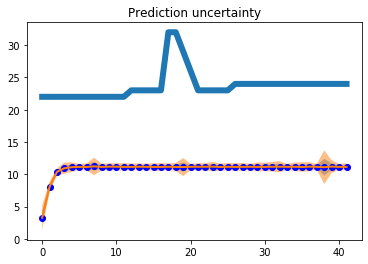

In [27]:
batch, df = predict(model3)

In [28]:
df

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,mu,upper,lower,two_upper,two_lower
0,2.520004,3.169095,2.813608,3.503923,3.200284,2.633394,2.677079,2.338699,3.370739,2.687015,...,3.445624,3.036135,3.681936,3.343717,3.249363,3.278250,4.223645,2.335991,5.169029,1.384446
1,8.144260,7.831451,8.584641,7.447587,8.125980,7.947928,8.499805,7.997172,8.095520,8.453283,...,8.084660,8.843734,8.069808,8.228208,8.597898,8.075335,8.469795,7.682183,8.864251,7.285156
2,10.118038,10.575229,10.418936,10.573967,10.448466,10.762465,10.452096,10.351050,10.441873,10.384582,...,10.881653,10.471814,10.343713,10.542174,10.332860,10.383631,10.653685,10.114472,10.923736,9.842661
3,10.997200,10.918936,10.781868,11.080874,10.903561,11.132705,11.132899,10.813924,11.285390,10.860274,...,10.878143,10.963457,11.002526,10.637629,10.388002,10.939642,11.377934,10.502804,11.816222,10.061660
4,11.017334,11.209843,11.015080,11.130910,11.158356,11.126230,11.079731,11.845776,11.080669,11.599308,...,10.904804,11.084570,11.009451,11.168296,11.021761,11.102331,11.470702,10.735181,11.839069,10.364413
5,11.106949,11.231707,11.252658,11.117980,11.190612,11.229085,11.154443,11.143032,11.089455,11.267656,...,11.081000,11.206156,11.193138,11.407222,11.191376,11.145685,11.372239,10.919882,11.598791,10.691853
6,12.200458,11.396229,11.026375,11.039749,11.317789,10.545129,11.155319,11.092995,11.148221,11.079152,...,11.230068,11.412875,11.008992,10.407582,11.113828,11.131004,11.404254,10.858661,11.677501,10.583634
7,10.965115,10.782147,11.021134,11.322035,11.178773,11.071583,11.169525,12.352010,11.112154,11.006003,...,11.315882,11.145496,10.815668,11.305048,11.325716,11.226843,11.906481,10.549460,12.586112,9.865400
8,10.986462,11.176124,10.768098,11.061940,11.247355,11.197940,11.125433,11.076212,11.149161,10.110487,...,11.143338,11.028492,11.418291,11.272382,11.174527,11.137622,11.390448,10.885634,11.643272,10.631163
9,11.150114,11.126731,11.610961,11.126799,11.254746,11.065773,11.313946,10.941088,11.144517,11.544477,...,11.172193,11.117752,11.103609,11.137480,11.119138,11.177742,11.444888,10.911483,11.712031,10.642599


### test

In [13]:
import tensorflow as tf
# Some Matrix A
A = tf.constant([[[3, 7],
                 [1, 9]],
                [[3, 7],
                 [1, 9]]])

A = tf.constant([[[3, 7],
                 [1, 9]],
                [[3, 7],
                 [1, 9]],
                [[3, 7],
                 [1, 9]]
                ])

#A = A.reshape((1,2,2))

# Some vector v
v = tf.constant([[5],
                 [2]])

# Matrix multiplication of A.v^T
Av = tf.matmul(A, v)

print(('Matrix Multiplication of A and v results in a new Tensor:\n{0}').format(
    Av
))

Matrix Multiplication of A and v results in a new Tensor:
[[[29]
  [23]]

 [[29]
  [23]]

 [[29]
  [23]]]


In [14]:
tf.shape(Av)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 2, 1], dtype=int32)>

In [15]:
tf.shape(A)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 2, 2], dtype=int32)>